In [11]:
# !ln -s /home/INM706-image-captioning/Datasets/coco/images/val2017/*.jpg /home/INM705_CW_Collins_Velagala/Datasets/coco/images/train2017/
!ln -s /home/INM706-image-captioning/Datasets/coco/images/train2017/*.jpg /home/INM705_CW_Collins_Velagala/Datasets/coco/images/train2017/

/bin/bash: /usr/bin/ln: Argument list too long


In [18]:
! pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 669.6 kB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import sys 
sys.path.append('../')

In [2]:
import os
from pathlib import Path
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

In [3]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

pick an easier problem:
<br> sofa	414	528	f
<br> signboard	398	1799	


https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [5]:
data_args = {'stage': 'val',
            'classes': ['motor_scooter', 'dining_table'], #'cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], #, 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
             'max_negative' : 0}
train_data = dataset_lvis.LVISData(**data_args)

classes : {1: 'dining_table', 2: 'motor_scooter'}
loaded 117 positive set images
loaded 0 negative set images
loaded 6 non-exhaustive set images
Loaded 111 images!
class 1 has 66 positive and 0 negative images
class 2 has 45 positive and 0 negative images
200 annotations found!
stage:  val
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  ../Datasets/coco/images/train2017


# Fine-tuning the model

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

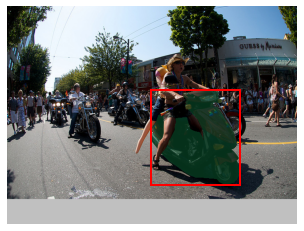

In [7]:
train_data.plot_img_with_ann(6, bboxes=True)

In [8]:
#Split dataset to test and train
indices = torch.randperm(len(train_data)).tolist()


dataset_train = torch.utils.data.Subset(train_data, indices[:100])
dataset_test = torch.utils.data.Subset(train_data, indices[100:])


train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=5, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


test_loader = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())



In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [14]:
checkpoint = Path('../model_checkpoints/model_45_epochs.pth')
helper.load_checkpoint(checkpoint, model, optimizer)

Loaded checkpoint ../model_checkpoints/model_45_epochs.pth!


In [53]:
importlib.reload(helper)

<module 'src.helper_functions' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/helper_functions.py'>

In [55]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 


num_epochs = 50
time_start = time.time() 


loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
#batch_loss = 0 


for epoch in range(num_epochs):
    model.train()
    
    #reset loss 
    batch_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_mask = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    
    
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        #save losses 
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_mask += loss_dict['loss_mask'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item() 
        
        losses = sum(loss for loss in loss_dict.values())
        batch_loss  += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    avg_batch_loss = batch_loss/(batch_num + 1) 
    
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [loss_classifier/(batch_num+1)],
          'loss_box_reg' : [loss_box_reg/(batch_num+1)],
           'loss_mask': [loss_mask/(batch_num+1)],
           'loss_objectness': [loss_objectness/(batch_num+1)],
           'loss_rpn_box_reg': [loss_rpn_box_reg/(batch_num+1)],
            'total_loss': avg_batch_loss 
          })     

    loss_df = pd.concat([loss_df, row], ignore_index = True, axis = 0)
    
    #save checkpoint every 5 epoch? 
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        #UNCOMMENT THIS 
        helper.save_checkpoint(checkpoint, fname)
    

    print(f"Loss after {epoch} epochs: {avg_batch_loss}")
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

Saved checkpoint model_0_epochs.pth!
Loss after 0 epochs: 0.7346931546926498
Loss after 1 epochs: 0.6406163334846496
Loss after 2 epochs: 0.5414760127663613
Loss after 3 epochs: 0.4758554965257645
Loss after 4 epochs: 0.41640646904706957
Saved checkpoint model_5_epochs.pth!
Loss after 5 epochs: 0.37349480763077736
Loss after 6 epochs: 0.3435978561639786
Loss after 7 epochs: 0.3117133446037769
Loss after 8 epochs: 0.2846500277519226
Loss after 9 epochs: 0.268795632570982
Saved checkpoint model_10_epochs.pth!
Loss after 10 epochs: 0.25624956339597704
Loss after 11 epochs: 0.2533120200037956
Loss after 12 epochs: 0.2377340830862522
Loss after 13 epochs: 0.23153778538107872
Loss after 14 epochs: 0.22397240474820138
Saved checkpoint model_15_epochs.pth!
Loss after 15 epochs: 0.21653294265270234
Loss after 16 epochs: 0.21784774959087372
Loss after 17 epochs: 0.20601678788661956
Loss after 18 epochs: 0.2028427381068468
Loss after 19 epochs: 0.20102126374840737
Saved checkpoint model_20_epochs

In [56]:
loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.128925,0.169356,0.396436,0.023269,0.016706,0.734693
1,1,0.111476,0.178684,0.323644,0.013293,0.01352,0.640616
2,2,0.084831,0.167179,0.268206,0.009156,0.012104,0.541476
3,3,0.067142,0.146879,0.244771,0.006808,0.010256,0.475855
4,4,0.057025,0.126775,0.218257,0.005348,0.009001,0.416406
5,5,0.046227,0.112191,0.203335,0.003636,0.008105,0.373495
6,6,0.040732,0.091814,0.200742,0.00323,0.00708,0.343598
7,7,0.0332,0.074333,0.194934,0.002422,0.006825,0.311713
8,8,0.03053,0.066095,0.17911,0.002905,0.00601,0.28465
9,9,0.02836,0.059146,0.173297,0.00243,0.005563,0.268796


# Plot loss 

<AxesSubplot:xlabel='epoch', ylabel='total_loss'>

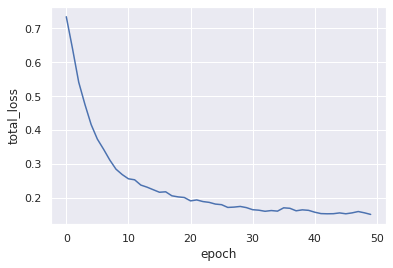

In [57]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

sns.lineplot(data=loss_df, x="epoch", y="total_loss")


# Test cases

In [24]:
from src import metrics

In [121]:
importlib.reload(metrics)

<module 'src.metrics' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/metrics.py'>

In [239]:
len(test_loader)

11

In [237]:
pred_boxes = []
gt = []
for idx, X, y in test_loader:
    model.eval()
    y_pred = model(X.to(device))
    # keep running list of predictions and ground truths
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred,
                                     pred_boxes, gt)

In [238]:
mAP_list = []
thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
for iou_thresh in thresholds:
    mAP_list.append(metrics.calculate_ap(pred_boxes, gt, 
                               iou_threshold=iou_thresh,
                               num_classes = len(train_data.class_idx_map)))

print('\n\n\n--------------\n\n')
for i in range(len(thresholds)):
    print(f'mAP for iou_threshold of {thresholds[i]}: {mAP_list[i]}')

30
class 1: len detections: 21
for category 1:
-------
TP and FP:
tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 18., 18., 18.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 2., 3.])
total gts 18
precisions and recalls:
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9474, 0.9000, 0.8571])
tensor([0.0556, 0.1111, 0.1667, 0.2222, 0.2778, 0.3333, 0.3889, 0.4444, 0.5000,
        0.5556, 0.6111, 0.6667, 0.7222, 0.7778, 0.8333, 0.8889, 0.9444, 1.0000,
        1.0000, 1.0000, 1.0000])
AP is 0.9999997019767761
-------

class 2: len detections: 9
for category 2:
-------
TP and FP:
tensor([1., 2., 3., 4., 5., 6., 7., 8., 8.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])
total gts 9
precisions and recalls:
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.

In [191]:
pred_boxes = []
gt = []

54


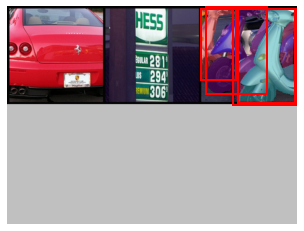

In [211]:
idx, X, y = next(iter(test_loader))
model.eval() 

print(idx[0])

#val_data.plot_img(idx[0])
train_data.plot_img_with_ann(idx[0], bboxes = True)

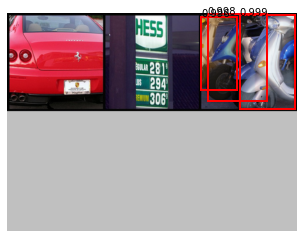

In [212]:
y_pred = model(X.to(device))
train_data.plot_predictions(idx[0], y_pred)
pred_boxes, gt = metrics.store_preds(idx, y, y_pred,
                                     pred_boxes, gt)

64


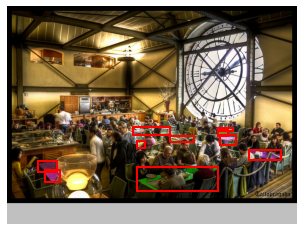

In [213]:
idx, X, y = next(iter(test_loader))
model.eval() 

print(idx[0])

#val_data.plot_img(idx[0])
train_data.plot_img_with_ann(idx[0], bboxes = True)

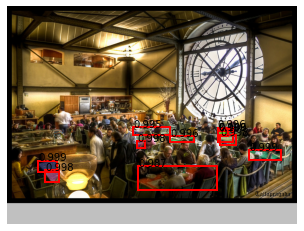

In [214]:
y_pred = model(X.to(device))
train_data.plot_predictions(idx[0], y_pred)
pred_boxes, gt = metrics.store_preds(idx, y, y_pred,
                                     pred_boxes, gt)

In [215]:
pred_boxes

[[21, 1, 0.9992550015449524, tensor([  2.9488,   0.0000, 286.1711, 480.0000])],
 [27, 1, 0.999207079410553, tensor([  0.6022, 175.7367, 361.1836, 475.3674])],
 [27, 1, 0.9964595437049866, tensor([168.3266,  27.8822, 292.1132,  93.2313])],
 [2, 1, 0.9970921277999878, tensor([  0.0000,  18.3150, 637.3899, 386.9357])],
 [2, 2, 0.20841382443904877, tensor([  4.9658, 479.9721,  13.6070, 480.0000])],
 [2, 1, 0.1985923796892166, tensor([  4.9150, 479.9721,  13.6476, 480.0000])],
 [59, 2, 0.9987234473228455, tensor([ 77.6728, 129.3989, 120.3098, 175.8577])],
 [59, 2, 0.9982312321662903, tensor([443.8428, 292.8944, 489.0070, 336.2656])],
 [59, 2, 0.9979652166366577, tensor([507.2760, 337.8141, 555.9227, 414.2068])],
 [59, 2, 0.997336208820343, tensor([569.5892, 240.4448, 639.8063, 291.6195])],
 [54, 2, 0.9985587000846863, tensor([512.7324,   3.4644, 633.7726, 210.3259])],
 [54, 2, 0.9977306723594666, tensor([442.1899,   1.7014, 573.6915, 193.8751])],
 [54, 2, 0.9959937334060669, tensor([427.988

In [216]:
gt

[[21, 1, tensor([  0.,   0., 287., 480.])],
 [27, 1, tensor([166.0275,  28.4025, 293.0275,  92.4025])],
 [27, 1, tensor([  0.0000, 180.8925, 360.0000, 479.8925])],
 [2, 1, tensor([  0.0000,  38.9000, 640.0000, 371.9000])],
 [59, 2, tensor([569.8900, 241.1500, 639.8900, 293.1500])],
 [59, 2, tensor([ 77.2500, 129.4200, 120.2500, 176.4200])],
 [59, 2, tensor([507.8300, 338.5400, 555.8300, 416.5400])],
 [59, 2, tensor([444.6200, 291.8300, 489.6200, 336.8300])],
 [54, 2, tensor([497.1648,   6.3104, 639.1648, 216.3104])],
 [54, 2, tensor([438.9248,   0.0000, 572.9248, 194.0000])],
 [54, 2, tensor([509.3888,   5.7728, 635.3888, 211.7728])],
 [54, 2, tensor([426.6112,   5.5680, 503.6112, 162.5680])],
 [64, 1, tensor([359.5200, 285.7400, 411.5200, 299.7400])],
 [64, 1, tensor([ 68.3700, 340.0700, 109.3700, 365.0700])],
 [64, 1, tensor([278.2400, 266.0800, 358.2400, 283.0800])],
 [64, 1, tensor([533.9600, 316.2100, 604.9600, 339.2100])],
 [64, 1, tensor([469.4400, 284.0500, 505.4400, 305.0500])

In [232]:
importlib.reload(metrics)

<module 'src.metrics' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/metrics.py'>

In [233]:
metrics.calculate_ap(pred_boxes, gt, iou_threshold=0.95, num_classes = len(train_data.class_idx_map))

24
class 1: len detections: 16
for category 1:
-------
TP and FP:
tensor([1., 2., 2., 3., 4., 5., 6., 7., 7., 8., 9., 9., 9., 9., 9., 9.])
tensor([0., 0., 1., 1., 1., 1., 1., 1., 2., 2., 2., 3., 4., 5., 6., 7.])
total gts 14
precisions and recalls:
tensor([1.0000, 1.0000, 0.6667, 0.7500, 0.8000, 0.8333, 0.8571, 0.8750, 0.7778,
        0.8000, 0.8182, 0.7500, 0.6923, 0.6429, 0.6000, 0.5625])
tensor([0.0714, 0.1429, 0.1429, 0.2143, 0.2857, 0.3571, 0.4286, 0.5000, 0.5000,
        0.5714, 0.6429, 0.6429, 0.6429, 0.6429, 0.6429, 0.6429])
AP is 0.543520450592041
-------

class 2: len detections: 8
for category 2:
-------
TP and FP:
tensor([1., 1., 1., 1., 2., 3., 3., 3.])
tensor([0., 1., 2., 3., 3., 3., 4., 5.])
total gts 8
precisions and recalls:
tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.4000, 0.5000, 0.4286, 0.3750])
tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.2500, 0.3750, 0.3750, 0.3750])
AP is 0.2218749076128006
-------



tensor(0.3827)

In [231]:
len(train_data.class_idx_map)

2

In [208]:
y = torch.tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000])
x = torch.tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000, 1.0000])
torch.trapz(y, x)

tensor(1.)

In [210]:
torch.trapz(y) / 5

tensor(0.9800)

In [60]:
gts = y[0]['boxes']#[0]
preds = y_pred[0]['boxes'].to('cpu').detach()#[0]

for i in range(len(gt)):
    gt = gts[i]   
    IOU = metrics.get_iou(preds, gt)
    print(IOU)

NameError: name 'gt' is not defined

In [ ]:
preds.shape

In [252]:


#get corners of predictions 
pred_x1 = preds[..., 0:1] 
pred_y1 = preds[..., 1:2]
pred_x2 = preds[..., 2:3]
pred_y2 = preds[..., 3:4]

#get corner of GT 
gt_x1 = gt[..., 0:1]
gt_y1 = gt[..., 1:2]
gt_x2 = gt[..., 2:3]
gt_y2 = gt[..., 3:4]

#print(pred_x1)
print(gt_x1.shape)

#get corners of intersection 
x1 = torch.max(pred_x1, gt_x1)
y1 = torch.max(pred_y1, gt_y1)
x2 = torch.min(pred_x2, gt_x2)
y2 = torch.min(pred_y2, gt_y2)

#print(x1)

intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0) 
pred_box_areas = abs((pred_x2-pred_x1) * (pred_y2-pred_y1))
gt_box_areas = abs((gt_x2-gt_x1) * (gt_y2-gt_y1))
union = pred_box_areas + gt_box_areas - intersection + 1e-6 #avoid divide by 0 

print(intersection/union)



torch.Size([2, 1])


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 0

In [254]:
from src import metrics

In [250]:
gt[0:1].shape

torch.Size([1])

In [212]:
preds[..., 0:1]

tensor([[ 23.0702],
        [274.5056],
        [  2.8543],
        [ 85.2058]])

In [210]:
torch.max(gt[0], preds[:, 0])

tensor([ 23.0702, 274.5056, 640.0000, 415.1300])

In [126]:
masks = y_pred[0]['masks'].to('cpu').detach().numpy()
masks.shape
for mask in maks 

(5, 1, 480, 640)

In [131]:
y_pred[0]['masks'][2, :, :, :].shape

torch.Size([1, 480, 640])

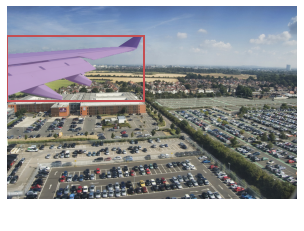

In [114]:
val_data.plot_predictions(idx[0], y)

In [88]:
masks = y[0]['masks'].to('cpu').detach().numpy()
len(masks)


2

In [192]:
scores = y_pred[0]['scores'].to('cpu').detach().numpy()
round(scores[3],3)

0.075

In [110]:
y_pred[0]['scores']

tensor([0.9879, 0.5249, 0.4059, 0.3417, 0.0594], device='cuda:0',
       grad_fn=<IndexBackward>)

NameError: name 'predictions' is not defined

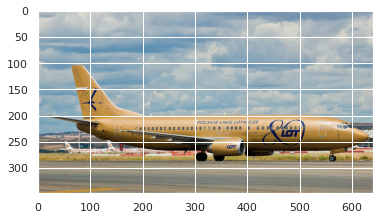

In [76]:
img_id = val_data.idx_img_map[idx[0]]
fname = str(img_id).zfill(12) + '.jpg'
path = val_data.imgs_dir + '/' + fname
im = PILImage.open(path)
#print(im.size)
show_bboxes = True

#Plots image 
plt.imshow(im)


if show_bboxes:
    bboxes = predictions['boxes'].to('cpu').detach().numpy()
    if len(bboxes) > 0:
        ax = plt.gca()        
        ax.axis('off')
        for id, b in enumerate(bboxes):
            #b = b[0] #get tuple
            rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

if show_masks:
    masks = predictions['masks'].to('cpu').detach().numpy()
    if len(masks) > 0:
        for m in masks:
            m = m[0, :, :]
            img = np.ones( (m.shape[0], m.shape[1], 3) )
            color_mask = np.random.random((1,3)).tolist()[0]
            for i in range(3):
                img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.5)))

plt.show()